In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

# Algoritmi genetici

Calculul maximului functiei $f: [-5, 10] \times [-3, 7] \rightarrow (0, \infty)$, unde functia este:

$$f(x, y) = cos\left(5\pi x + \frac{10}{1 + y^2}\right) + ln(x^2 + y^4+10)$$


In [2]:
def read_GA_file(input_file_path:str) -> Tuple[List[float],List[float]]:
    """Read the values produced by a genetic algorithm, as found in file given in :param input_file_path:
    :param input_file_path: the input file path, containing output produced by a GA algorithm. 
    :return: a touple two lists. The first list contains the average value of each generation.The second list contains 
    the max value of each generation. Both lists has same length NR."""
    with open(input_file_path, 'rt') as f:
        lines = f.readlines()
    lines = [line for line in lines if len(line.strip()) > 0] # remove empty entries
    lines_start_generation = [i for i, line in enumerate(lines) if line.startswith('#inceput date generatie')]
    lines_end_generation = [i for i, line in enumerate(lines) if line.startswith('#sfarsit date generatie')]
    
    # check for paired start-end notifications
    assert len(lines_start_generation) == len(lines_end_generation) 
    # start block right after end of previous block
    assert np.all(np.array(lines_start_generation[1:]) - 1 == np.array(lines_end_generation[:-1])) 
    
    result_mean_generations = [] # a list of floating point values, with mean of each generation
    result_best_generations = [] # a list of floating point values, with max of each generation
    
    for start_index, end_index in zip(lines_start_generation, lines_end_generation):
        values_current_population = []
        for index_line in range(start_index+2, end_index, 2): # step 2 because we do not use the x and y values of the chromosome
            line = lines[index_line]
            assert line.startswith('valoare: ')
            value_chromosome = float(line.split(': ')[1])
            values_current_population.append(value_chromosome)
        result_mean_generations.append(np.mean(values_current_population))
        result_best_generations.append(np.max(values_current_population))
    
    return result_mean_generations, result_best_generations

In [3]:
def plot_GA(result_mean_generations:List[float], result_best_generations:List[float]) -> None:
    """Plots the evolutions of the genetic populations.
    :return: None"""
    generations = range(len(result_mean_generations))
    f, ax = plt.subplots(figsize=(20, 10))
    
    ax.plot(result_mean_generations, label='Generation mean')
    ax.plot(result_best_generations, 'g', label='Generation best')
    ax.set_xticks(generations)
    ax.set_xlabel('Generation number')
    ax.set_ylabel('Fitness value')
    ax.set_title('Population evolution')
    ax.legend(loc='best')

In [4]:
#the value of the function f calculated according to x and y given as parameters. 
def f(x:float, y:float)->float:
    return np.cos(np.pi * 5 * x + 10/(1 + y**2)) + np.log(x**2 + y**4+10)

In [5]:
#Convert the value of v to a value within the interval [a, b].
#k-the bits' number
def mapping_on_interval(v:int, a:int, b:int, k:int):
    return a+v*(b-a)/(2**k-1)

In [6]:
#generates another 2 chromosomes 
#in which first 't' bits from 'a' and from 'b' will be reversed between the chromosomes.
def crossover_chr(a:int, b:int, t:int, k:int):
    x=np.binary_repr(a, width=k)
    y=np.binary_repr(b, width=k)
    c="0b"+x[:t]+y[t:]
    d="0b"+y[:t]+x[t:]
    c=int(c, base=2)
    d=int(d, base=2)
    return  c,d

In [7]:
#selects some chromosomes from population and makes crossover between them, on pairs, 
#where the pc is the probability of crossover
def crossover(population, k, pc = 0.1):
    new_population=[]
    for i in population:
        nr=np.random.rand(1)+np.finfo(np.float64).eps  
        if(nr<pc):
            new_population.append(i)
            population.remove(i)
    if(len(new_population)>1):
        for i in range(0,len(new_population)-1,2):
            a,b=crossover_chr(new_population[i],new_population[i+1],4,k)
            new_population[i]=a
            new_population[i+1]=b
    new_population=new_population+population
    return new_population

In [8]:
#resets/sets a bit from a chromosome
def mutate_chr(a:int, t:int, k:int):
    x="0b"+np.binary_repr(a, width=k)
    print(x)
    position=k-t+1
    if(x[k-t+1]=='1'):
        x=x[:position]+"0"+x[position+1:]
    else:
        x=x[:position]+"1"+x[position+1:]
    print(x)
    x=int(x,base=2)
    return x

In [9]:
#resets/sets a bit from a chromosome, where pm is the probability of mutation

def mutation(population:list, k:int, pm:float = 0.01):
     for i in range(len(population)):
        for j in range(k):
            nr=np.random.rand(1)*0.1+np.finfo(np.float64).eps
            if nr<pm:
                print(j)
                population[i]=mutate_chr(population[i],j,k)
                print()
            
    return population

In [10]:
#returns the maximum value of the objective function for the given population.

def maximum(population, k):
    maxi=float('-inf')
    poz=-1
    for j in range(len(population)):
        x=population[j]
        x=np.binary_repr(x, width=k)
        h=f(mapping_on_interval(int("0b"+x,base=2),-5,10,k), mapping_on_interval(int("0b"+x,base=2),-3,7,k))
        maxi=max(maxi,h)
        poz=j
    return maxi,poz

In [11]:
#receives population of chromosomes, along with k, the length of a chromosome
#creates and returns a new generation.

def selection(population, k):
    
    y=[]
    for element in population:
        x=np.binary_repr(element, width=k)
        h=f(mapping_on_interval(int('0b'+x,base=2),-5,10,k), mapping_on_interval(int('0b'+x,base=2),-3,7,k))
        y.append(h)
        
    s=np.sum(y)
    p=y/s
    
    cdf=[]
    suma=0
    for i in range(len(p)):
        suma=suma+p[i]
        cdf.append(suma)
    
    h=[]
    new_population=[]
    for i in range(len(population)):
        nr=np.random.rand(1)+np.finfo(np.float64).eps
        for j in range(0,len(cdf)):
            if(nr<cdf[j]):
                new_population.append(population[j])
                h.append(f(mapping_on_interval(int("0b"+x,base=2),-5,10,k), mapping_on_interval(int("0b"+x,base=2),-3,7,k)))
                break
    return new_population

In [ ]:
file = open("output.txt", "w")
k=20
n = 50
generatii=20
population = np.random.randint(0,2**k, size=50)
#Populatia initiala

values=[]
for generatie in range(generatii+1):
    line='#inceput date generatie '+str(generatie)+'\n'
    file.write(line)
    for i in range(n):    
        population=selection(population,k)
        #Populatia dupa selectie
        population=crossover(population,k,0.1)
        #Populatia dupa incrucisare
        population= mutation(population, k, 0.01)
        #Populatia  dupa mutatie
        
        maxim,poz=maximum(population,k)
        nr_x=mapping_on_interval(population[poz],-5,10,k)
        nr_y=mapping_on_interval(population[poz],-3,7,k)
        line='cromozom: x=' + str(nr_x) +' y=' + str(nr_y) +'\n' + 'valoare: '+ str(maxim)+'\n'
        file.write(line)
    line='#sfarsit date generatie '+str(generatie)+'\n'
    file.write(line)
file.close()

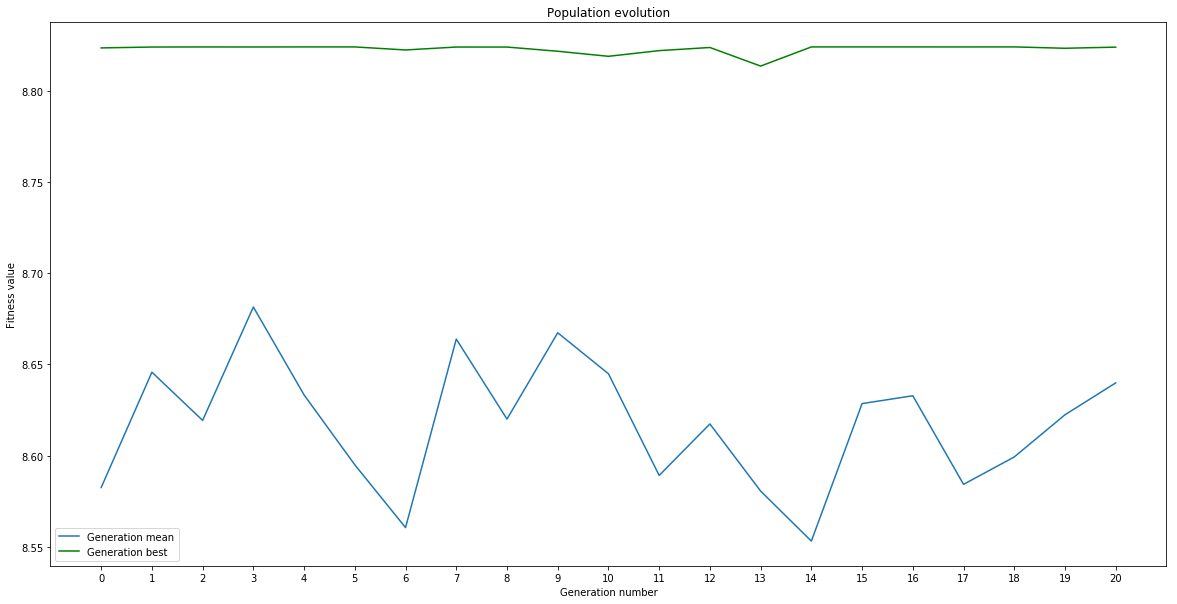

In [32]:
file_name = 'output.txt'
result_mean_generations, result_best_generations = read_GA_file(file_name)
plot_GA(result_mean_generations, result_best_generations)